In [ ]:
%pip install git+https://github.com/peng-lab/BaSiCpy@dev

In [2]:
%pip install --upgrade aicsimageio "aicspylibczi>=3.0.5"

Note: you may need to restart the kernel to use updated packages.


In [12]:
import xarray

xarray.__version__
import numpy as np
from os import path
import os
from aicsimageio import AICSImage
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
from skimage.transform import resize
from skimage.filters import try_all_threshold

from skimage.morphology import binary_dilation, binary_erosion

# from cucim.skimage.morphology import binary_erosion, disk

from skimage.filters import (
    threshold_multiotsu,
    threshold_isodata,
    try_all_threshold,
    threshold_otsu,
    threshold_triangle,
    threshold_li,
    threshold_yen,
    threshold_mean,
    threshold_minimum,
    threshold_local,
    threshold_niblack,
    threshold_sauvola,
    threshold_otsu,
)
from basicpy import BaSiC

In [3]:
file_path = "./organoid_confocal.czi"
img = AICSImage(file_path, reconstruct_mosaic=False)
data = img.data
img.dims

<Dimensions [M: 16, T: 40, C: 2, Z: 21, Y: 128, X: 128]>

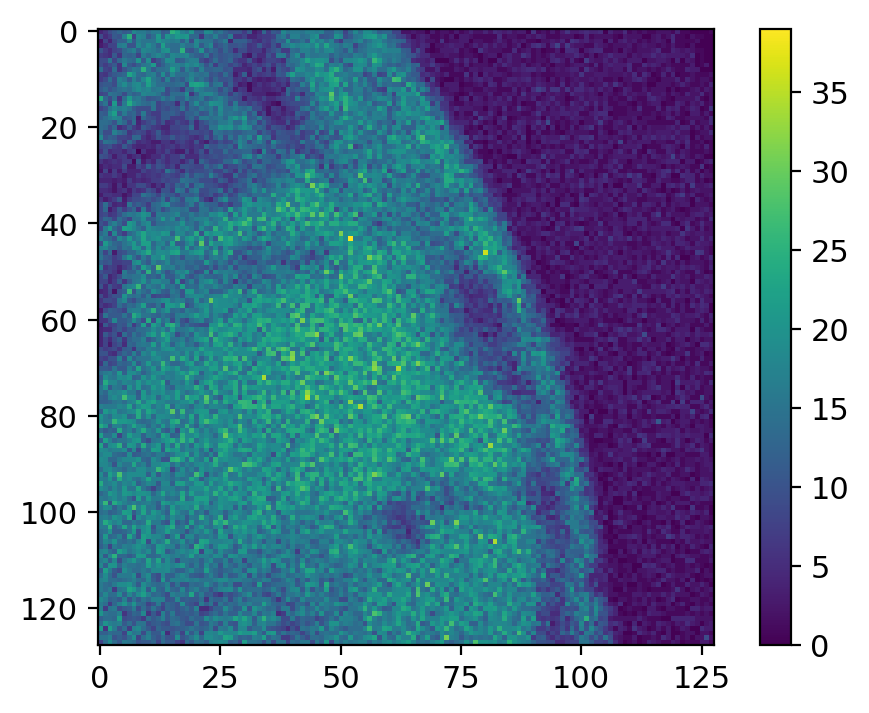

In [13]:
plt.imshow(data[4, 1, 0, 10, :, :])
plt.colorbar()

In [14]:
mosaic_poss = np.array(
    [img.get_mosaic_tile_position(m, C=0, Z=0) for m in range(img.shape[0])]
)
mosaic_poss[:, 0] = mosaic_poss[:, 0] - np.min(mosaic_poss[:, 0])
mosaic_poss[:, 1] = mosaic_poss[:, 1] - np.min(mosaic_poss[:, 1])
mosaic_poss

array([[  0,   0],
       [  0, 127],
       [  0, 255],
       [  0, 382],
       [127, 382],
       [127, 255],
       [127, 127],
       [127,   0],
       [255,   0],
       [255, 127],
       [255, 255],
       [255, 382],
       [382, 382],
       [382, 255],
       [382, 127],
       [382,   0]])

In [15]:
stitched_image = np.zeros(
    list(img.shape[1:-2])
    + [
        img.shape[-2] + np.max(mosaic_poss[:, 0]),
        img.shape[-1] + np.max(mosaic_poss[:, 1]),
    ]
)
for m in range(img.shape[0]):
    mp = mosaic_poss[m]
    stitched_image[
        ..., mp[0] : mp[0] + img.shape[-2], mp[1] : mp[1] + img.shape[-1]
    ] = img.dask_data[m, ...]

In [16]:
zs = np.arange(0, 21, 5)
zs

array([ 0,  5, 10, 15, 20])

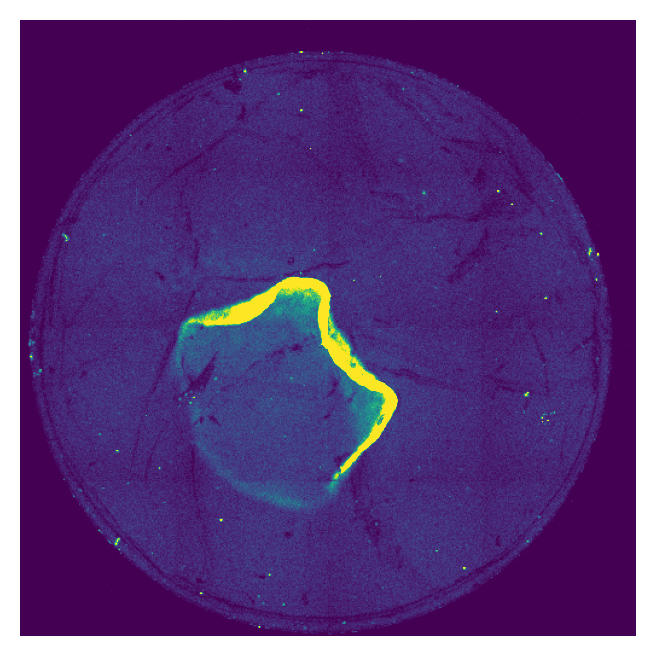

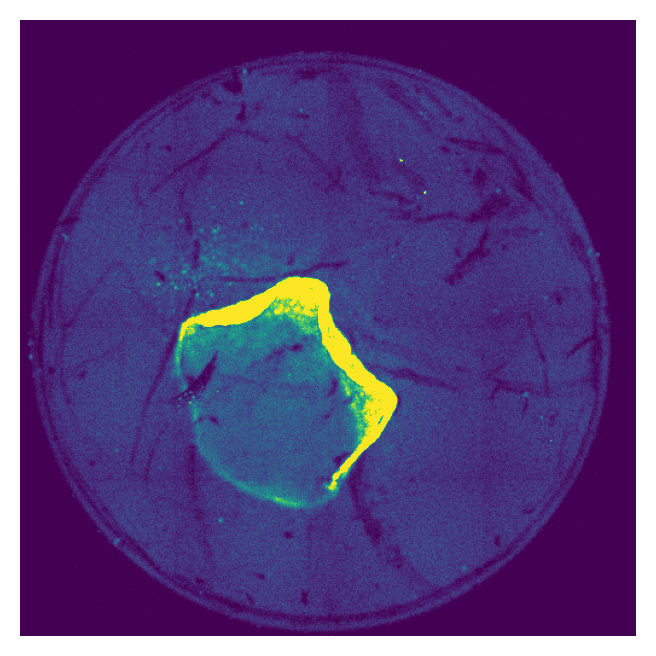

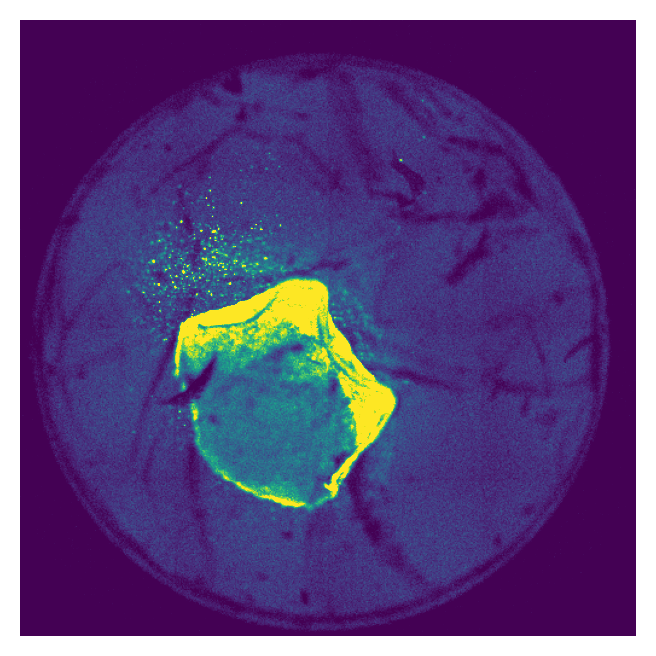

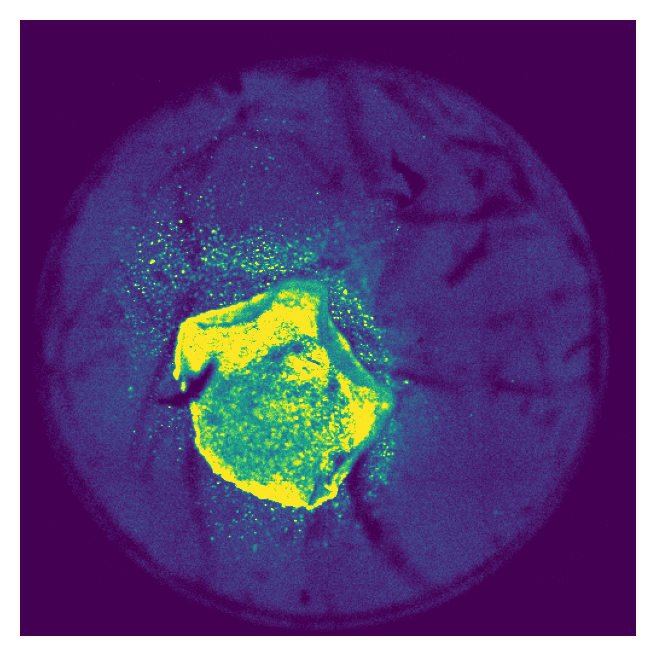

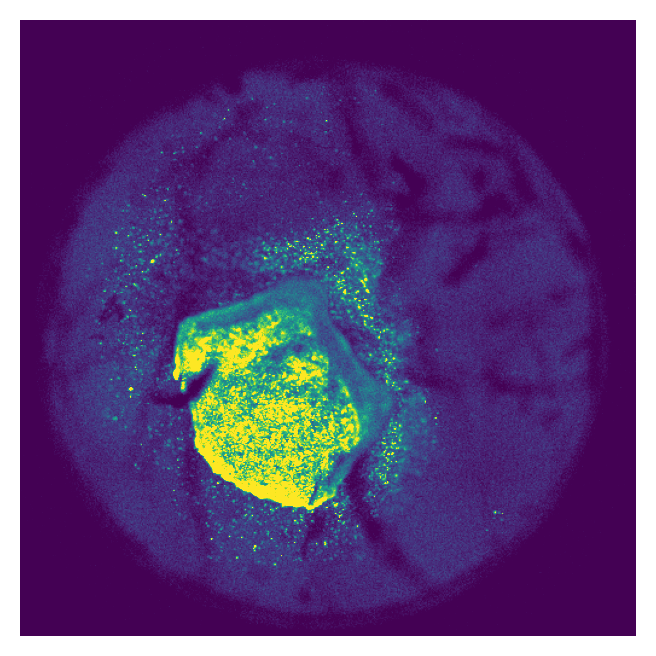

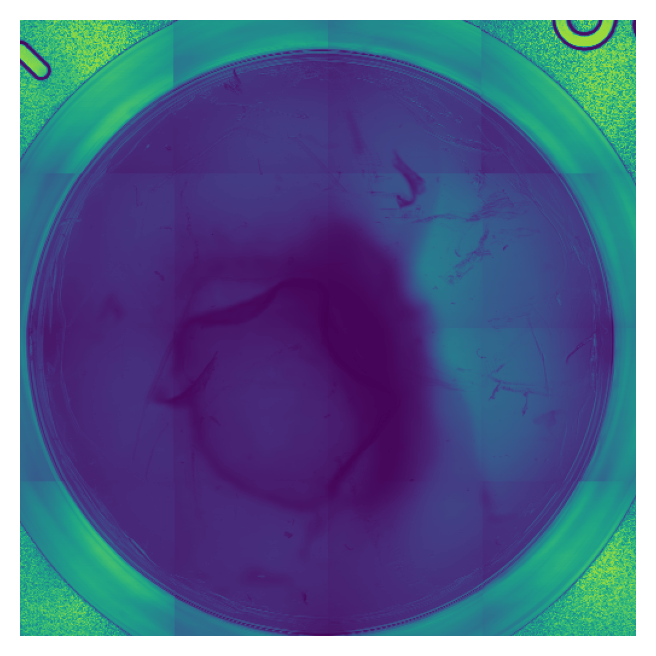

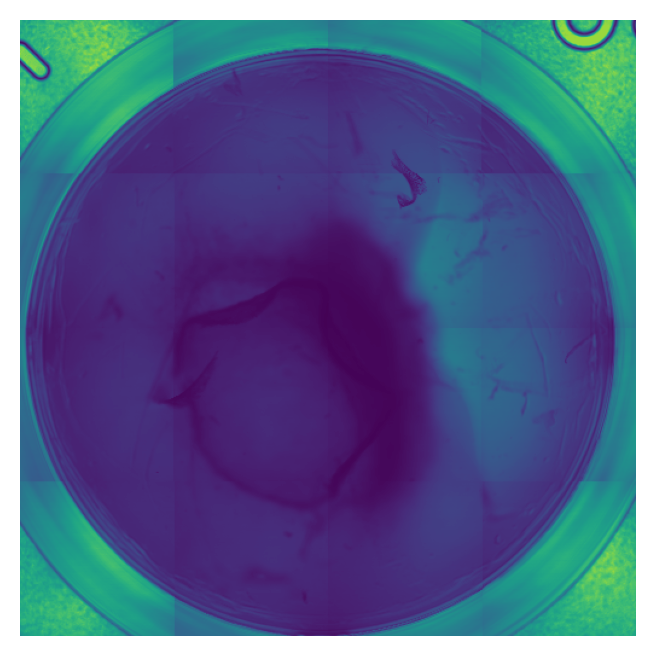

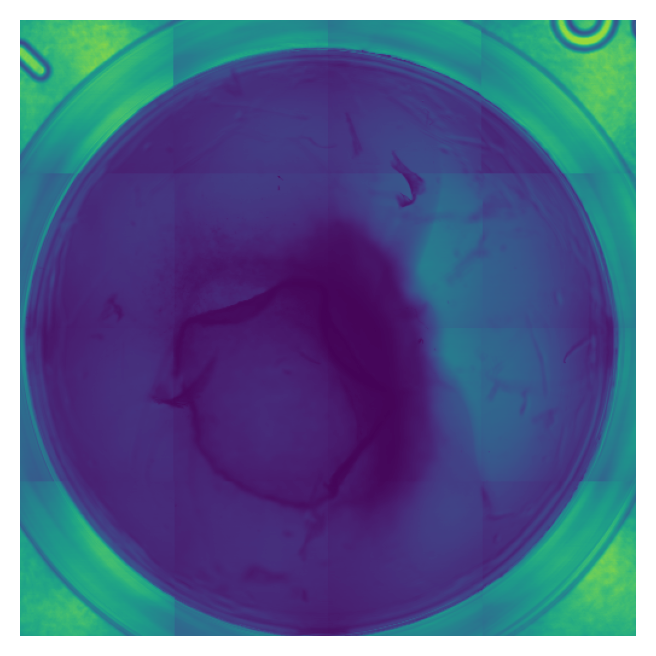

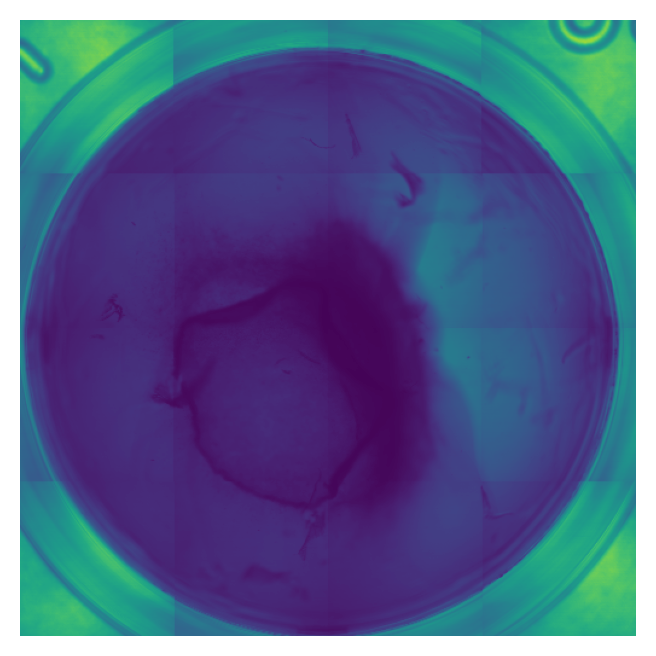

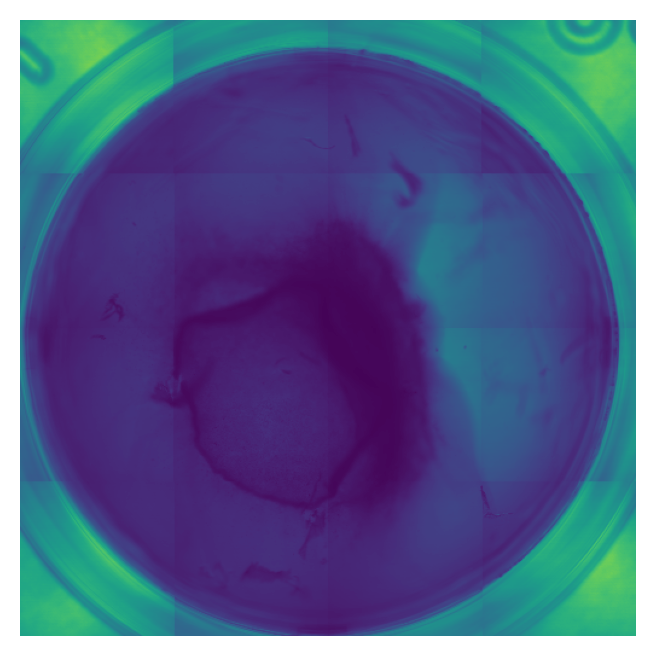

In [17]:
import os

os.makedirs("stitched_examples", exist_ok=True)
for c in range(img.shape[2]):
    for z in zs:
        plt.imshow(
            stitched_image[0, c, z],
            vmin=[5, 0][c],
            vmax=[100, 300][c],
        )
        plt.axis(False)
        plt.savefig(f"stitched_examples/uncorrected_{c}_{z}.png")
        plt.show()

(40, 2, 21, 510, 510)

In [18]:
img_shadow_corrs = np.array(
    [
        data[:, :, c, :, :, :].reshape((data.shape[0] * data.shape[1], *data.shape[3:]))
        for c in range(data.shape[2])
    ]
)
print(img_shadow_corrs.shape)
# C, MT, Z, Y, X

(2, 640, 21, 128, 128)


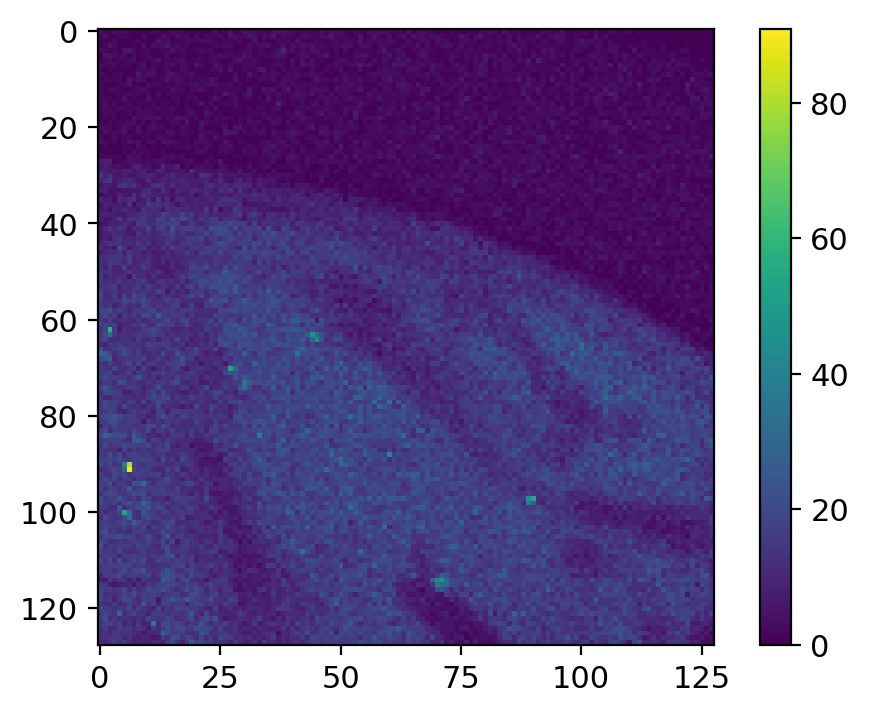

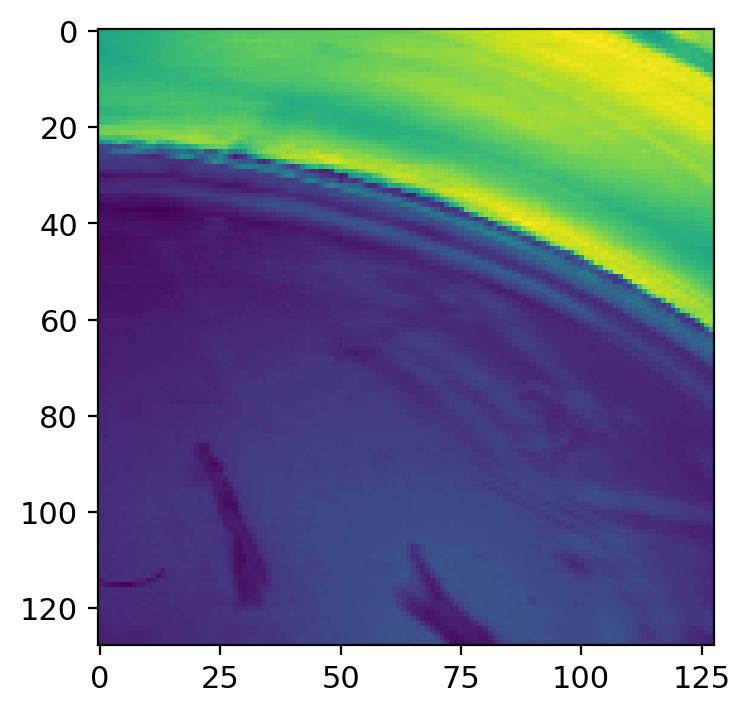

In [19]:
plt.imshow(img_shadow_corrs[0, 100, 10])
plt.colorbar()
plt.show()
plt.imshow(img_shadow_corrs[1, 100, 10])
plt.show()

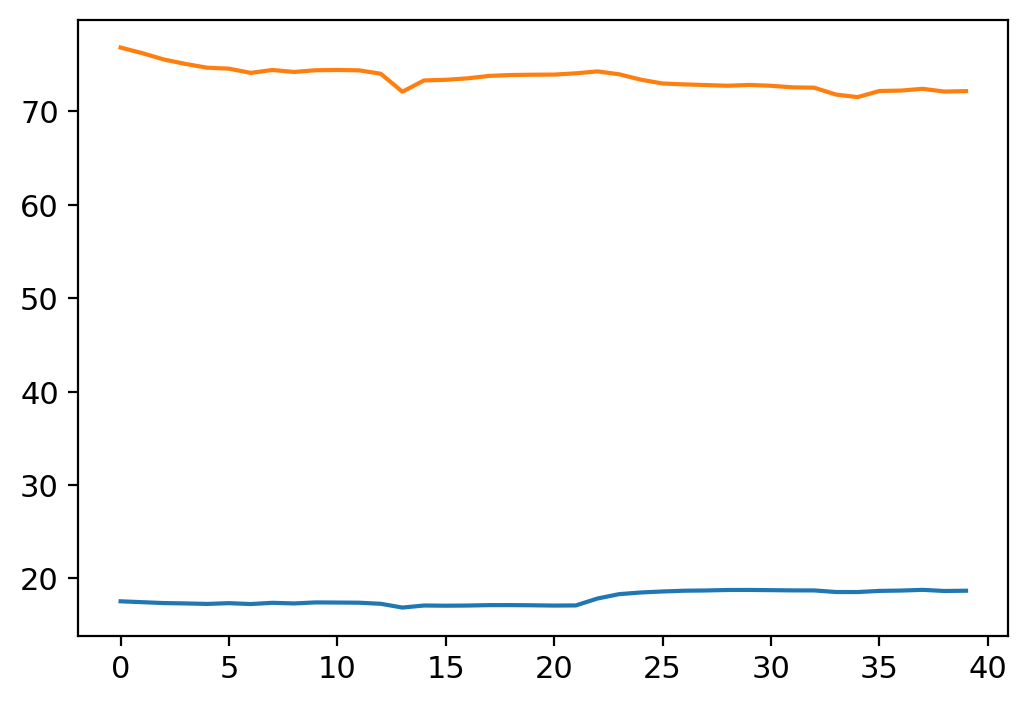

In [29]:
ave = data.mean(axis=(0, 3, 4, 5))
plt.plot(ave[:, 0])
plt.plot(ave[:, 1])

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


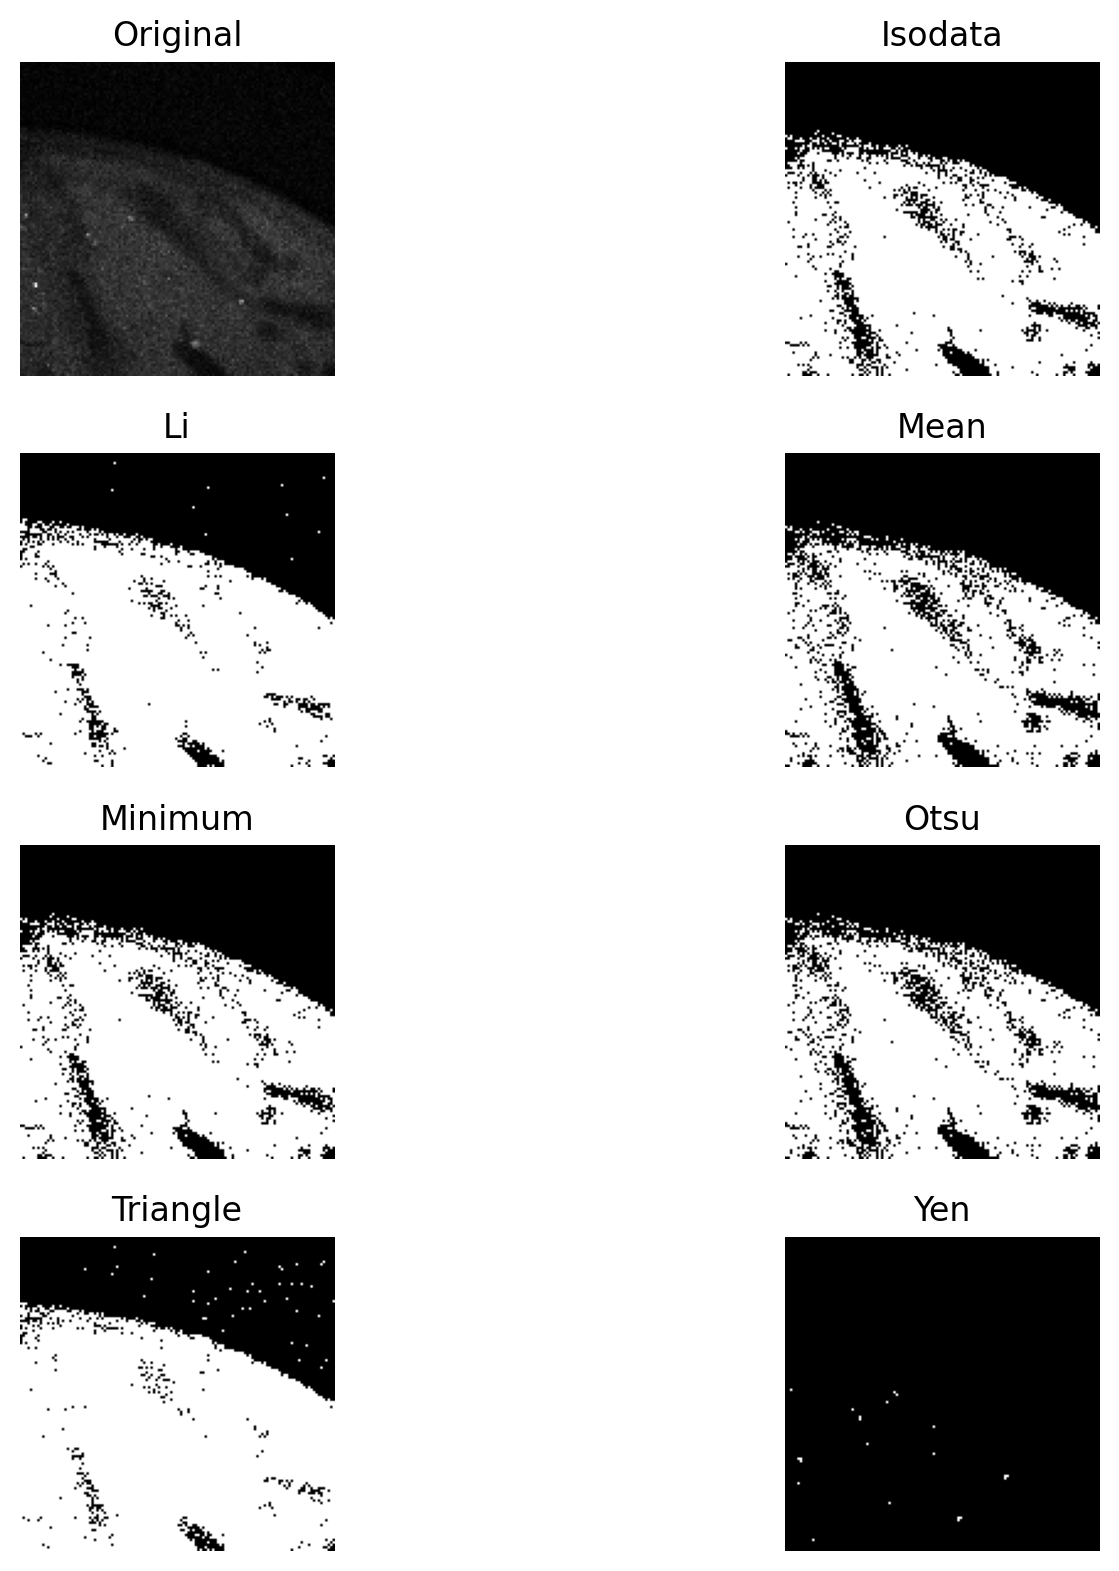

In [21]:
fig, ax = try_all_threshold(img_shadow_corrs[0, 100, 10], figsize=(10, 8), verbose=True)
plt.show()

In [22]:
thresholds = [
    threshold_otsu(img_shadow_corrs[c]) for c in range(img_shadow_corrs.shape[0])
]
print(thresholds)

[66, 101]


(array([5.000e+02, 1.225e+03, 1.472e+03, 1.113e+03, 6.870e+02, 4.290e+02,
        3.210e+02, 3.470e+02, 4.110e+02, 4.950e+02, 5.720e+02, 0.000e+00,
        6.550e+02, 7.650e+02, 8.130e+02, 8.660e+02, 9.040e+02, 7.980e+02,
        7.950e+02, 7.290e+02, 6.360e+02, 4.910e+02, 0.000e+00, 3.890e+02,
        2.970e+02, 2.060e+02, 1.340e+02, 1.000e+02, 8.100e+01, 5.200e+01,
        2.000e+01, 2.600e+01, 1.000e+01, 0.000e+00, 7.000e+00, 9.000e+00,
        7.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

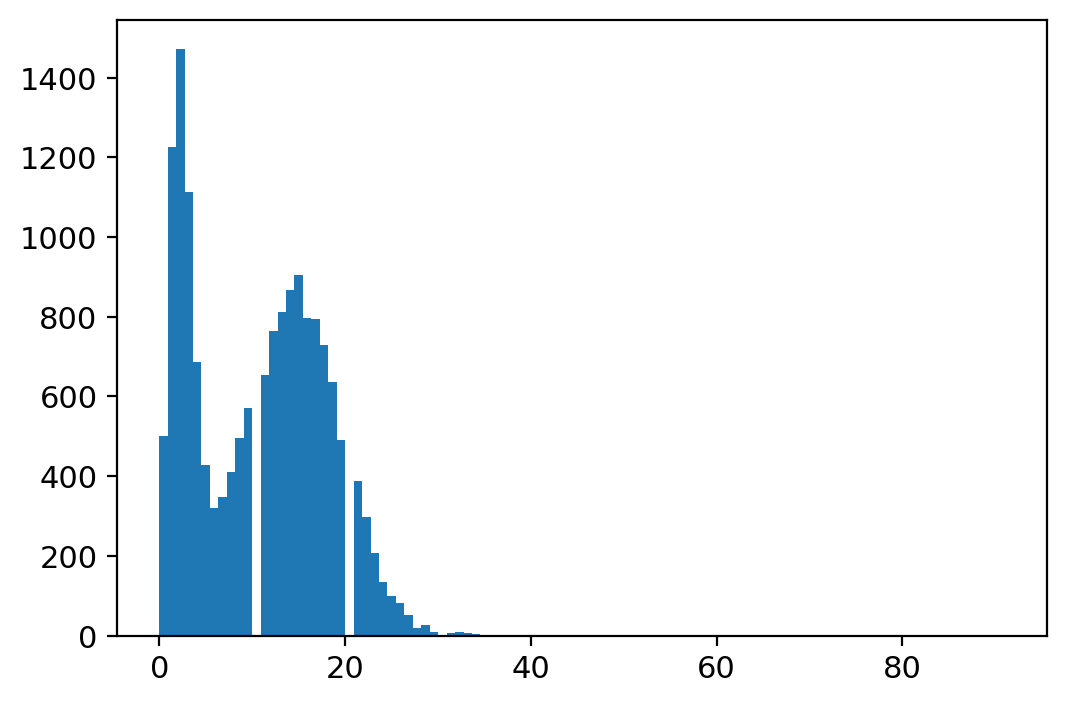

In [56]:
plt.hist((img_shadow_corrs[0])[100, 10].flatten(), bins=100)

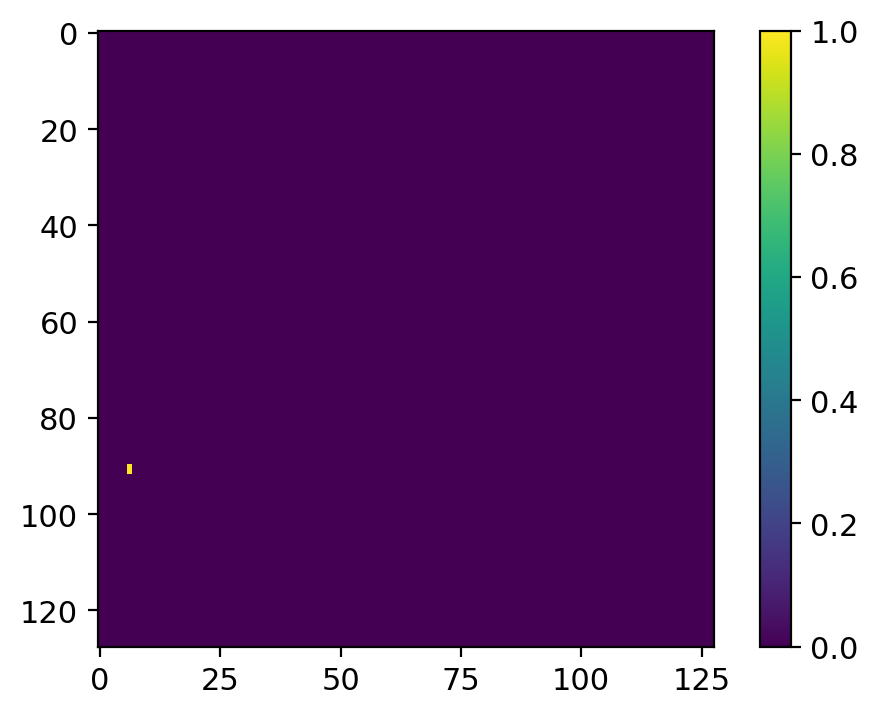

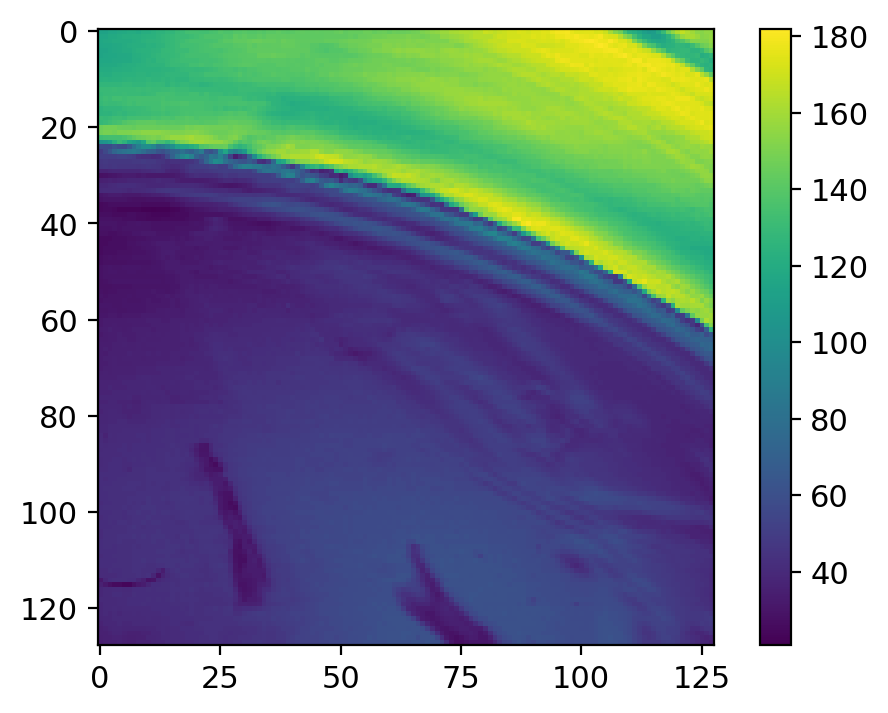

In [55]:
plt.imshow((img_shadow_corrs[0])[100, 10] > thresholds[0])
plt.colorbar()
plt.show()
plt.imshow((img_shadow_corrs[1])[100, 10])
plt.colorbar()
plt.show()

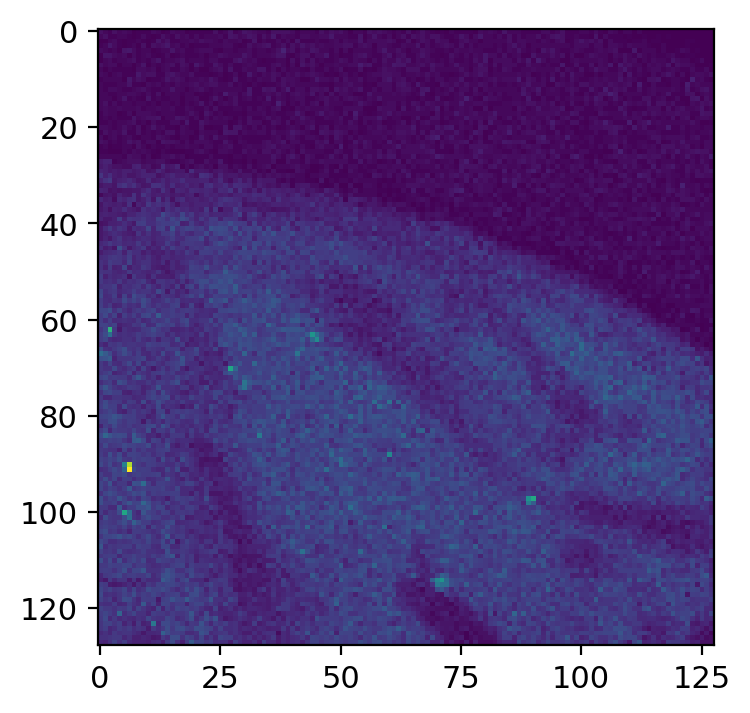

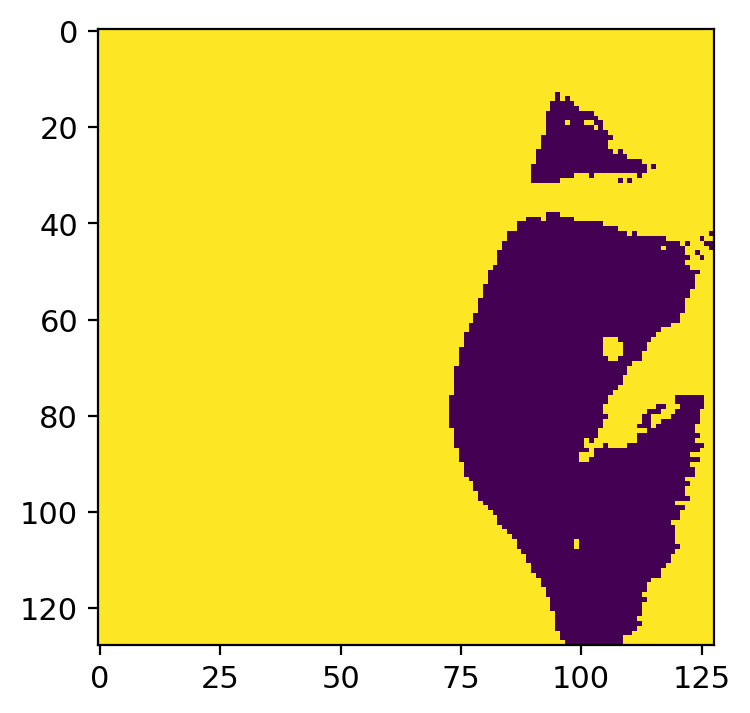

In [49]:
plt.imshow((img_shadow_corrs[0][100, 10]))
plt.show()
plt.imshow((img_shadow_corrs[1][100, 10] < thresholds[1]))
plt.show()

(640, 21, 128, 128)


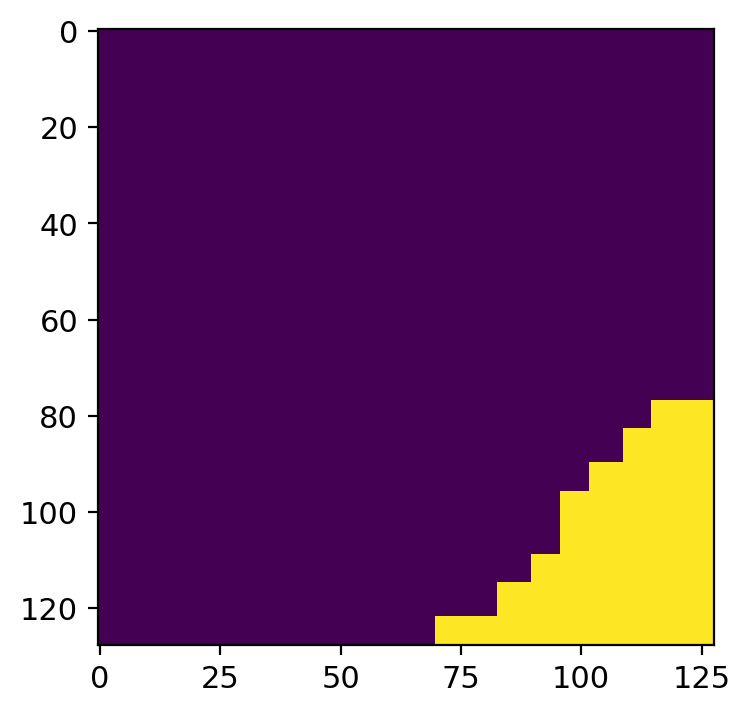

In [15]:
thresholded = img_shadow_corrs[1] < thresholds[1][0]
original_shape = thresholded.shape
print(original_shape)

i = 0


def erosion(im):
    im = resize(binary_erosion(im), (original_shape[2], 20, 20), anti_aliasing=False)
    im = binary_erosion(im, footprint=np.ones((1, 3, 3)))
    im = resize(im, original_shape[1:], anti_aliasing=False)
    return im


im = erosion(thresholded[i, ...])
plt.imshow(im[10])

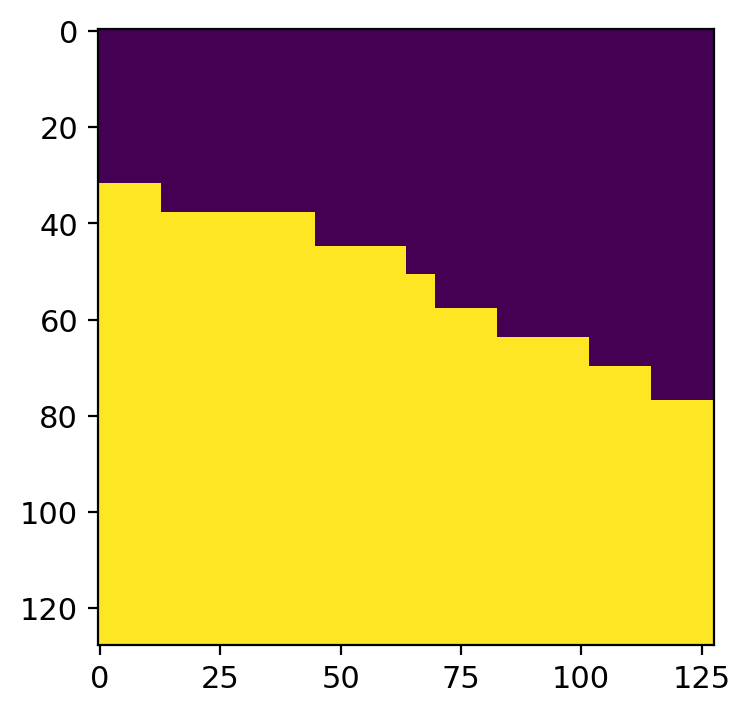

In [16]:
mask = np.array([erosion(thresholded[i, ...]) for i in range(original_shape[0])])
weights = np.array(
    [
        img_shadow_corrs[0] < thresholds[0][0],
        mask,
    ]
).astype(np.float32)
del mask
del thresholded
plt.imshow(weights[1, 100, 10])

In [17]:
print(weights.shape)
print(weights.dtype)

(2, 640, 21, 128, 128)
float32
